In [106]:
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import periodogram
import seaborn as sns
import tqdm
import wfdb

In [4]:
df = pd.read_csv('ptb-xl-ecg/ptbxl_database.csv')

In [84]:
df.iloc[2]

ecg_id                                                   3
patient_id                                         20372.0
age                                                   37.0
sex                                                      1
height                                                 NaN
weight                                                69.0
nurse                                                  2.0
site                                                   0.0
device                                           CS-12   E
recording_date                         1984-11-15 12:49:10
report                          sinusrhythmus normales ekg
scp_codes                       {'NORM': 100.0, 'SR': 0.0}
heart_axis                                             NaN
infarction_stadium1                                    NaN
infarction_stadium2                                    NaN
validated_by                                           NaN
second_opinion                                       Fal

In [85]:
tmp = wfdb.rdrecord('ptb-xl-ecg/records100/00000/00003_lr')
tmp = tmp.to_dataframe()

In [86]:
def plot_ecg_line(
        ax, 
        timesteps,
        value_mV,
        lead_name,
        ms_per_mm=40,
        mV_per_mm=0.1
    ):
    
    x_ms = timesteps / timedelta(milliseconds=1)
    ax.plot(x_ms, value_mV, color='k', alpha=1, linewidth=0.8)
    ax.set_ylabel(lead_name)
    ax.set_xticks(np.arange(-100, x_ms[-1] + 200, ms_per_mm))
    ax.set_yticks(np.arange(-1.5, 1.5, mV_per_mm))
    ax.set_xticks(np.arange(-100, x_ms[-1] + 200, 5 * ms_per_mm), minor=False)
    ax.set_yticks(np.arange(-1.5, 1.5, 5 * mV_per_mm), minor=False)
    ax.minorticks_on()
    ax.grid(which='major', color='red', linestyle='-', linewidth=0.8, alpha=0.6)
    ax.grid(which='minor', color='red', linestyle='-', linewidth=0.3, alpha=0.3)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(which='both', top=False, bottom=False, left=False, right=False)
    ax.set_xlim(-200, x_ms[-1] + 200)
    ax.set_aspect(400, adjustable='box')
    return ax

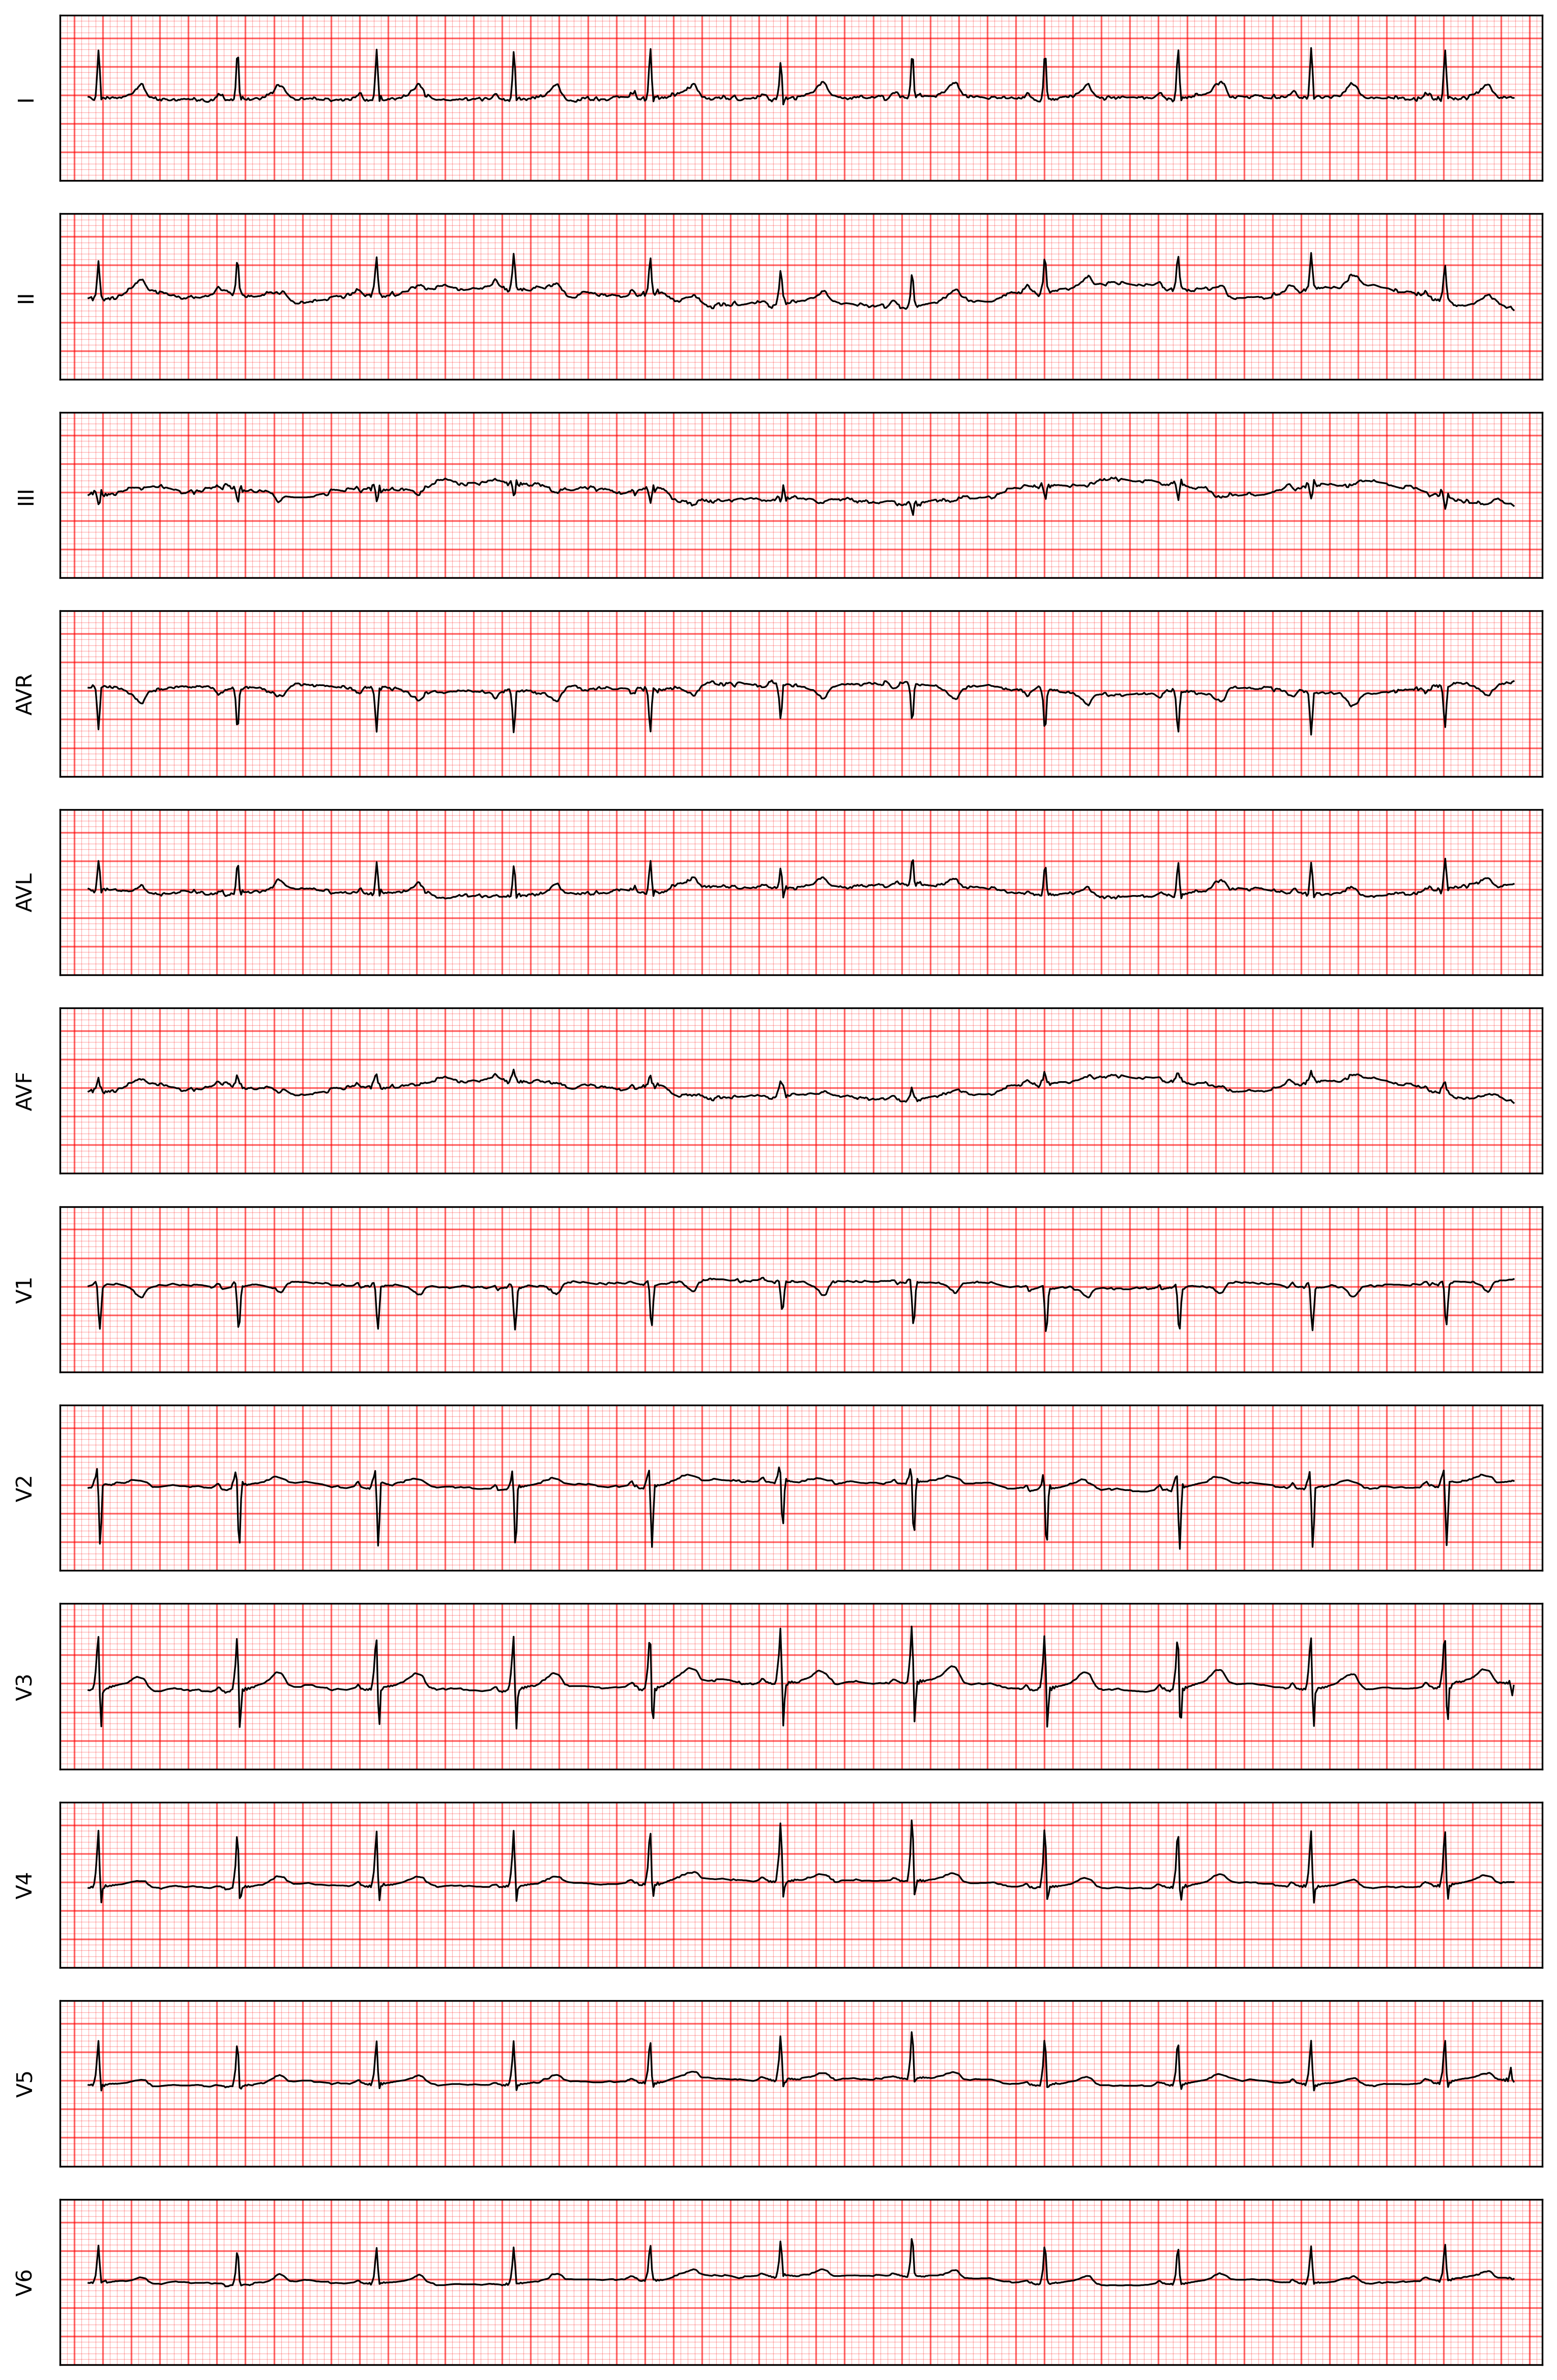

In [87]:
fig, axs = plt.subplots(12, 1, figsize=(20, 20), sharex=True, dpi=300)
axs = axs.flatten()

for i, ax in enumerate(axs):
    lead_name = tmp.columns[i]
    x = tmp.index
    y = tmp.iloc[:, i]
    plot_ecg_line(ax, x, y, lead_name)

In [111]:
def autocorrelation(data: np.array, type='standard') -> np.array:
    data = data[~np.isnan(data)]
    data_sub = data - data.mean()
    acfs = []
    denominator = np.sum(data_sub ** 2)
    if type == 'standard':
        for lag in tqdm.trange(len(data)):
            acfs.append(np.dot(data_sub[:len(data) - lag], data_sub[lag:]))
    else: # circular
        for lag in tqdm.trange(len(data)):
            acfs.append(np.dot(data_sub, np.concatenate([data_sub[lag:], data_sub[:lag]])))
    return np.array(acfs) / denominator

In [153]:
acf_res = autocorrelation(tmp.I.values)
peak_locs = []
peaks = []
lag_window = 3
acf_cutoff = 0.1
for i, v in enumerate(acf_res):
    if v >= acf_res[max(0, i - 5):].max() and v > acf_cutoff:
        peak_locs.append(i)
        peaks.append(v)

100%|██████████| 1000/1000 [00:00<00:00, 310000.30it/s]


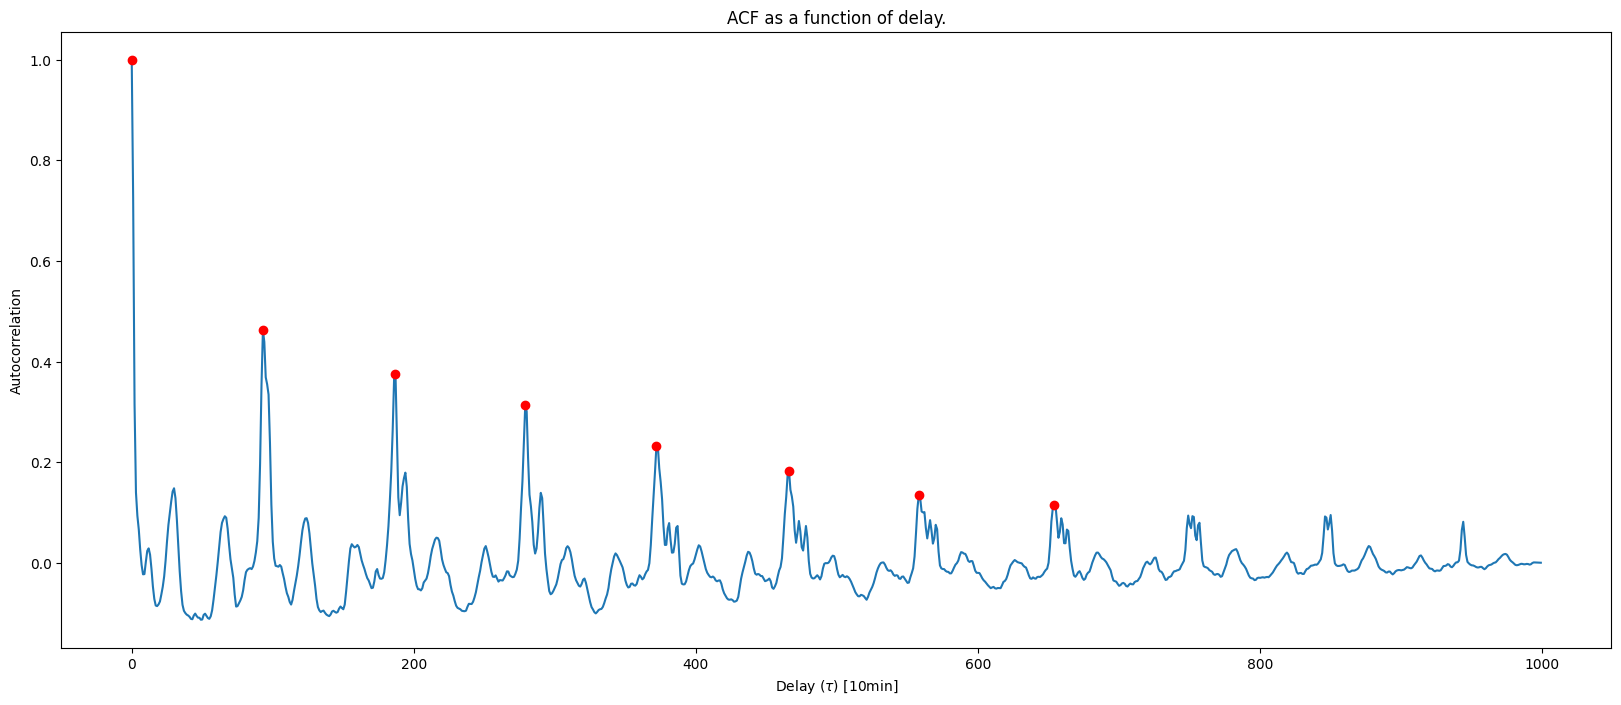

In [154]:
lags = len(acf_res)
plt.figure(figsize=(20, 8))
plt.plot(range(lags), acf_res, zorder=-1)
plt.scatter(peak_locs, peaks, c='r', zorder=1)
plt.ylabel('Autocorrelation')
plt.xlabel('Delay ($\\tau$) [10min]')
plt.title('ACF as a function of delay.')
plt.show()

In [156]:
peak_locs

[0, 93, 187, 279, 372, 466, 558, 654]